In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
from mysql.connector import Error
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [2]:
#name_lens_cat = '../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl'
path_to_data = '../../CLCosmo_Sim_database/data/'
name_lens_cat = path_to_data + 'random_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl'
ra_name, dec_name, z_name = 'ra', 'dec', 'redshift'
obs_name = 'richness'
lens_cat = np.load(name_lens_cat, allow_pickle = True)
ra, dec, z = lens_cat['ra'], lens_cat['dec'], lens_cat['redshift']

In [3]:
n_rand = 3000
rmax = 10
Drandoms1_Mpc = np.random.random(n_rand)*(rmax+rmax)-rmax
Drandoms2_Mpc = np.random.random(n_rand)*(rmax+rmax)-rmax
mask = Drandoms1_Mpc**2+Drandoms2_Mpc**2 < rmax**2

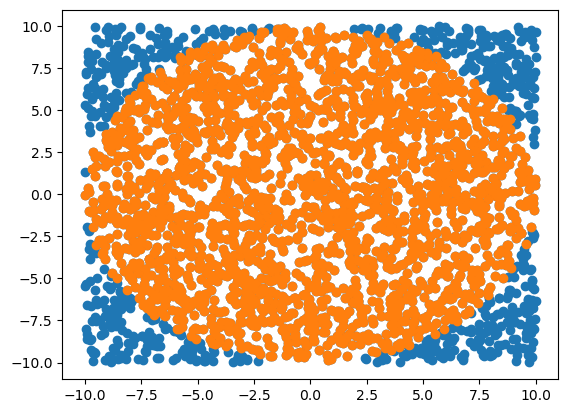

In [ ]:
plt.scatter(Drandoms1_Mpc, Drandoms2_Mpc)
plt.scatter(Drandoms1_Mpc[mask], Drandoms2_Mpc[mask])

In [5]:
mask_avoid = []
for k in range(len(lens_cat)):
    ra_k, dec_k, z_k = ra[k], dec[k], z[k]
    dtheta1_deg = (Drandoms1_Mpc[mask]/cosmo.eval_da_z1z2(0, z_k))*(180/np.pi)
    dtheta2_deg = (Drandoms2_Mpc[mask]/cosmo.eval_da_z1z2(0, z_k))*(180/np.pi)
    randoms1_k_ra_deg, randoms2_k_dec_deg = ra_k + dtheta1_deg, dec_k + dtheta2_deg
    healpix_list_k = np.unique(healpy.ang2pix(32,randoms1_k_ra_deg,
                                              randoms2_k_dec_deg, nest=False,lonlat=True))
    mask_is_in = np.isin(healpix_list_k, healpix_dc2)
    mask_avoid.append(len(mask_is_in[mask_is_in==True])!=len(mask_is_in))
mask_avoid = np.array(mask_avoid)

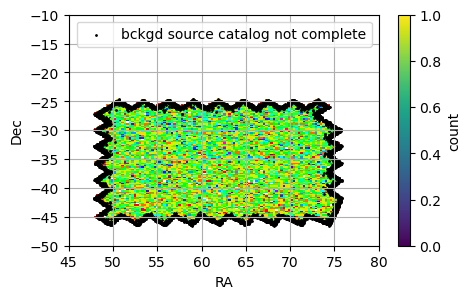

In [6]:
suff = '_random'
plt.figure(figsize=(5,3))
plt.hist2d(ra, dec, bins=100, cmap='hsv', cmin=1,)
plt.scatter(ra[mask_avoid], dec[mask_avoid], s=1, color='k', label = 'bckgd source catalog not complete')
plt.colorbar(label = 'count')
plt.grid()
plt.xlim(45, 80)
plt.ylim(-50, -10)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
plt.savefig(f'../fig/redmapper_clusters_surveys_geometrical_limits{suff}.png', bbox_inches='tight', dpi=100)

In [7]:
np.save('cluster_id_with_partial_coverage'+suff, lens_cat['cluster_id'][mask_avoid])